# Project Motivation

## Related Works
- **Prompt-Tuning** methods such as [CoOp](https://arxiv.org/pdf/2109.01134) and [CoCoOp](https://arxiv.org/pdf/2203.05557) are prone to overfitting on the few-shot examples available per class. While they address the problem from the prompt level i.e. language modality, they do not consider, hence leverage CLIP's shared embedding space between both vision and language modalities.

- On the other hand, **Visual Adapters** like [CLIP-Adapter](https://arxiv.org/pdf/2110.04544) tackle the problem of few-shot-learning from the visual level by learning a residual on vision features (i.e. CLS token embedding from the ViT architecture) through a bottleneck layer. However, much like prompt-tuning methods (CoOp and CoCoOp), visual adapters are also prone to overfitting on the available few-shots per class and alone, lack linguistics context provided by the textual prompts.


## Analyses to Motivate the Work
To motivate the proposed method, two analyses were performed on CLIP-Adapter and CoOp after reproducing their results:
1. The first analysis investigated if performance degradation on unseen classes was tied to distance in embedding space between the *learned* prompt (concatenatic CoOp's context tokens with the class tokens) and the *original* frozen prompt.

<div style="text-align: center;">

<img src="https://i.postimg.cc/28r653Yw/clip-analysis.png" alt="image_caption" width="900">

*Figure 1: Comparison of embedding distance vs. accuracy. Drifting too far from the original prompt correlates with reduced generalization accuracy on unseen classes.*

</div>

2. Similarly, the second analysis assesses how visual features given by CLIP's frozen encoder diverged in embedding space from the learned representations by CLIP-Adapter i.e., the adapted features. The goal was to determine if high divergence would correlate with a drop in performance on unseen classes. 

    The results are shown in the figure below:
   
<div style="text-align: center;">

<img src="https://i.postimg.cc/L4z5RLcg/clip-adapter-analysis.png" alt="image_caption" width="900">

*Figure 2: Empirical analysis showing that divergence in embedding space between adapted and non-adapted visual features is strongly correlated with performance degradation on novel classes*

</div>

## Problem Statement
The issue with existing approaches is that, in base-to-novel settings, they do not perform well as they:
1. Fail to fully exploit the shared embedding space between both vision and language modalities.
2. Lack active regularization to prevent overfitting on base classes and keep generalization performance on novel classes compared to CLIP zero-shot performance.

## High Level Idea
The objective of this project is to:
1. **Combine** the two above mentioned approaches to leverage the shared embedding space between both vision and language modalities
2. **Constrain** the learning of context tokens (for the language side) to yield text embeddings too far from frozen CLIP embeddings
3. **Regularize** the learning of adapted visual features to prevent them from diverging too much from frozen CLIP embeddings.

All of these while still managing to learn task-specific features that helps discriminate better among (seen) base classes during training.

## Method
This project implements a teacher-student framework.
- The teacher is a frozen CLIP model.
- The student builds upon the CLIP model with both additional learnable prompt tokens  and a learnable visual adapter i.e. bottleneck head.

Given an input image $\mathbf{x}$, a visual encoder $\phi(\cdot)$, a text encoder $\psi_(\cdot)$, a set of hand-crafted prompts $\mathbf{P}$ and a set of learnable context tokens $\mathbf{\text{ctx}}$, the student is trained to simultaneusly:
- minimize the distance between the learned, adapted visual features $(\phi_{\text{student}}(x) )$ and the visual features produced by frozen CLIP's visual encoder $(\mathbf{V}_{\text{teacher}})$ via a Kullback-Leibler divergence between the student's and teacher's logits and 
- minimize the distance between the learned, adapted text embeddings $(\psi_{\text{student}}([\mathbf{\text{ctx}}, \mathbf{P}]))$ with CoOp's context tokens and the text embeddings produced by frozen CLIP's text encoder $(\psi_{\text{teacher}}(\mathbf{P}))$ via a simple cosine similarity between the two.

More specifically, the final loss function is given by:

$$
\mathcal{L}_{\text{student}} = \alpha \mathcal{L}_{\text {CE}} + (1-\alpha) \mathcal{L}_{\text{vis}} + \beta \mathcal{L}_{\text{txt}}
$$

where $\mathcal{L}_{\text CE}$ is the standard **cross-entropy loss** and $\mathcal{L}_{\text{vis}}$ is the **Visual Distillation Loss** defined as the Kullback-Leibler divergence between the student's (vision) and teacher's logits defined as:
$$
\mathcal{L}_{\text{vis}} = \text{KL}(\mathbf{p}_{\text{student}} || \mathbf{p}_{\text{teacher}})
$$ 
where $\mathbf{p}_{\text{teacher}} = \cos(\phi_{\text{teacher}}(x), \psi_{\text{teacher}}([\mathbf{\text{ctx}}, \mathbf{P}]))$ and $\mathbf{p}_{\text{student}} = \cos(\phi_{\text{student}}(x), \psi_{\text{student}}([\mathbf{\text{ctx}}, \mathbf{P}]))$.

$\mathcal{L}_{\text{txt}}$ is the cosine similarity between the student's embeddings produced with CoOp's context tokens and the teacher's embeddings produced without any addition to the hand-crafted prompt. Formally, it is defined as: 
$$
\mathcal{L}_{\text{txt}} = 1 - \cos(\psi_{\text{student}}([\mathbf{\text{ctx}}, \mathbf{P}]), \psi_{\text{teacher}}(\mathbf{P}))
$$

Note: Although the KL loss operates on the final logits, rather than directly on the visual feature vectors, it indirectly enforces the student's visual features to be close to the teacher's by matching the output distribution structure.

# Importing necessary libraries

In [1]:
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oyb0xaxi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-oyb0xaxi
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
# @title Imports

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import torchvision
from torchvision.datasets.flowers102 import Flowers102
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn, optim
import clip
import random
import numpy as np
from PIL import Image
import copy
from itertools import chain

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 43

## Utility Functions

In [19]:
# @title Generic Utilities
# -- Reproducibility utils --

def set_seed(seed: int = 42):
    """
    Settings used for reproducibility purposes.
    https://pytorch.org/docs/stable/notes/randomness.html
    """
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Torch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Seed set to {seed}")


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def base_novel_categories(dataset) -> tuple[list[int], list[int]]:
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base_classes = list(range(num_classes))[:num_classes // 2]
    novel_classes = list(range(num_classes))[num_classes // 2:]
    return base_classes, novel_classes


def harmonic_mean(base_accuracy, novel_accuracy):
    numerator = 2
    denominator = 1 / base_accuracy + 1 / novel_accuracy
    hm = numerator / denominator
    return hm


def get_data(data_dir='./data', transform=None) -> tuple[Flowers102,
                                                         Flowers102,
                                                         Flowers102]:
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = Flowers102(
        root=data_dir, split="train", download=True, transform=transform)
    val = Flowers102(
        root=data_dir, split="val", download=True, transform=transform)
    test = Flowers102(
        root=data_dir, split="test", download=True, transform=transform)
    return train, val, test


def split_data(dataset, base_classes):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we create a set of base classes to compute the test below in O(1)
    # this is optional and can be removed
    base_set = set(base_classes)

    # here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # here we create the dataset subsets
    # the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    # https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset


def accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()


@torch.no_grad()
def eval_with_class_subset(model, dataloader, class_indices):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logit_scale = student_model.logit_scale.exp()

        # get full predictions
        img_feats, text_feats = model(images)
        #print(f"text features shape {text_feats.shape}")

        # getting only the text features for the relevant classes
        text_feats = text_feats[class_indices, :]

        #print(f"selected text features shape {text_feats.shape}")

        # map labels to indices in the selected subset
        if class_indices[0] == 0:  # base classes
            labels_subset = labels  # unchanged
        else:  # novel
            labels_subset = labels - len(class_indices)

        logits = logit_scale * img_feats @ text_feats.t()
        loss = F.cross_entropy(logits, labels_subset)

        total_loss += loss.item()
        total_acc += accuracy(logits, labels_subset)

    return total_loss / len(dataloader), total_acc / len(dataloader)

@torch.no_grad()
def eval_clip_zero_shot(model, dataloader, text_features, class_indices):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    # retrieving only relevant text features
    text_features = text_features[class_indices, :] # shape: (51, 512)

    for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # map labels to indices in the selected subset
        if class_indices[0] == 0:  # base classes
            labels_subset = labels  # unchanged
        else:  # novel
            labels_subset = labels - len(class_indices)
        
        # forward image through CLIP image encoder
        image_features = model.encode_image(images)
        # and normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)

        logit_scale = model.logit_scale.exp()
        
        logits = logit_scale * image_features @ text_features.t()
        loss = F.cross_entropy(logits, labels_subset)

        total_loss += loss.item()
        total_acc += accuracy(logits, labels_subset)
        
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [4]:
# @title Training Utilities
def train_one_epoch(
    teacher_model,
    student_model,
    dataloader,
    optimizer,
    base_indices,
    teacher_text_feats, # never change during training
    alpha=0.5,
    beta=0.2,
    temperature=2.0
):
    teacher_model.train()
    total_loss, total_acc = 0.0, 0.0

    # selecting base classes text_features ONLY
    teacher_text_feats = teacher_text_feats[base_indices, :]

    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # student forward pass
        student_img_feats, student_text_feats = student_model(imgs)  #  img feats shape: [B, 512], txt feats shape: [102, 512]
        # print("student text_features shape: ", student_text_feats.shape)

        # retrieving base classes text features ONLY
        student_text_feats = student_text_feats[base_indices, :]  # shape: (51, 512)

        # teacher forward pass
        with torch.no_grad():
            dtype = teacher_model.dtype
            teacher_img_feats = teacher_model.visual(imgs.type(dtype))
            teacher_img_feats /= teacher_img_feats.norm(dim=-1, keepdim=True).clamp(min=1e-12)
            # print("teacher text_features shape: ", teacher_text_feats.shape)

        # calculate student and teacher logits
        logit_scale = student_model.logit_scale.exp()
        student_logits = logit_scale * student_img_feats @ student_text_feats.t()
        # note: vision logits are the cos. sim between teacher img feats (non adapted) and student text feats (adapted with CoOp).
        teacher_vision_logits = logit_scale * teacher_img_feats @ student_text_feats.t()

        # CE loss on base classes only
        ce_loss = F.cross_entropy(student_logits, labels)

        # visual distillation loss (KL div.) with temperature
        vision_kl_loss = F.kl_div(
            F.log_softmax(student_logits / temperature, dim=-1),
            F.softmax(teacher_vision_logits / temperature, dim=-1),
            reduction='batchmean'
        ) * (temperature ** 2)

        # text feature-based KD loss
        text_kd_loss = 1 - F.cosine_similarity(
            student_text_feats, teacher_text_feats, dim=-1
        ).mean()

        # combined loss (vision_KD + text_KD + CE)
        loss = (alpha * ce_loss + (1 - alpha) * vision_kl_loss) + beta * text_kd_loss # (visual KL + CE + text KD)
        #loss = (alpha * ce_loss + (1 - alpha) * vision_kl_loss) # (visual KL + CE)
        #loss = ce_loss + beta * text_kd_loss # (CE + text KD)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy(student_logits, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)


def train_loop(
    teacher_model,
    student_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    base_indices,
    teacher_text_feats,
    epochs=10,
    alpha=0.5,
    beta=0.2,
    temperature=2,
    model_state_path='adapter_weights.pt'
):
    best_val_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch: {epoch}/{epochs}")

        train_loss, train_acc = train_one_epoch(
            teacher_model, student_model, train_loader, optimizer,
            base_indices, teacher_text_feats, alpha, beta, temperature
        )
        val_loss, val_acc = eval_with_class_subset(student_model, val_loader, base_indices)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"[LR] Current learning rate: {current_lr:.6f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc.: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc.: {val_acc:.4f}")

        # save model    
        best_val_acc = val_acc
        best_vision_adapter_state = copy.deepcopy(student_model.vision_adapter.state_dict())
        best_ctx_state = copy.deepcopy(student_model.text_adapter.state_dict())
        torch.save(best_ctx_state, "ctx_state.pt")
        torch.save(best_vision_adapter_state, "vision_adapter_state.pt")
        print(f"✅ New model saved (val_acc = {best_val_acc:.4f})")


    return history

# Model Definition

### CLIP-Adapter

In [ ]:
# @title Adapters (CoOp and CLIP-Adapter)

class VisionAdapter(nn.Module): # Slightly modified version of CLIP-Adapter
    def __init__(self, c_in, reduction=4, dropout=0.5):
        super(VisionAdapter, self).__init__()

        hidden_dim = c_in // reduction
        self.net = nn.Sequential(
            nn.Linear(in_features=c_in, out_features=hidden_dim, bias=False),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=hidden_dim, out_features=c_in, bias=False),
        )

    def forward(self, x):
        x = self.net(x)  # residual
        return x


class TextAdapter(nn.Module): # CoOp text adapter
    def __init__(self, classnames, clip_model, n_ctx=16):
        super(TextAdapter, self).__init__()
        self.classnames = classnames
        self.dtype = clip_model.dtype

        ctx_dim = clip_model.ln_final.weight.shape[0]  # context dimension
        self.ctx = nn.Parameter(torch.empty(n_ctx, ctx_dim))  # tokens to be learned
        nn.init.normal_(self.ctx, std=0.02)

        prompt_prefix = " ".join(['X'] * n_ctx)
        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        temp = 'a photo of a {}, a type of flower.'
        prompts = [temp.format(c) for c in classnames]
        prompts = [prompt_prefix + " " + p for p in prompts]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)

        with torch.no_grad():
            embeddings = clip_model.token_embedding(tokenized_prompts).type(self.dtype)

        # structure is: [BOS] [class tokens ... ] [EOS]
        self.register_buffer("token_prefix", embeddings[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embeddings[:, 1 + n_ctx :, :])  # class tokens + EOS
        self.tokenized_prompts = tokenized_prompts

    def forward(self, token_embeddings):
        # append the learnable context to the end of the token embeddings
        ctx = self.ctx.unsqueeze(0).expand(token_embeddings.shape[0], -1, -1)
        return torch.cat([
            self.token_prefix,  # BOS
            ctx,  # learned context
            self.token_suffix,  # class tokens + EOS
        ], dim=1).type(self.dtype)


### Custom CLIP (Student)

In [6]:
# @title CustomCLIP

class CustomCLIP(nn.Module): # Student model with both visual and text adapters
    def __init__(
        self,
        classnames: list[str],
        clip_model: nn.Module,
        vision_adapter_args,
        text_adapter_args,
        vision_ratio: float = 0.2,
        vision_adapter_state=None,
        text_adapter_state=None 
    ):
        super().__init__()
        self.classnames = classnames
        self.dtype = clip_model.dtype
        self.clip_model = clip_model
        self.vision_ratio = vision_ratio
        self.logit_scale = clip_model.logit_scale
        self.image_encoder = clip_model.visual

        # create and attach adapters
        vision_feature_dim = self.image_encoder.output_dim
        self.vision_adapter = VisionAdapter(vision_feature_dim, **vision_adapter_args)
        self.text_adapter = TextAdapter(classnames, clip_model, **text_adapter_args)

        if vision_adapter_state:
            self.vision_adapter.load_state_dict(vision_adapter_state)

        if text_adapter_state:
            self.text_adapter.load_state_dict(text_adapter_state)

    def encode_image_with_adapter(self, image):
        image_features = self.image_encoder(image.type(self.dtype))
        adapted_features = self.vision_adapter(image_features.float()).type(self.dtype)
        combined_features = self.vision_ratio * adapted_features + (1 - self.vision_ratio) * image_features
        # norm & return
        return combined_features / combined_features.norm(dim=-1, keepdim=True)

    def encode_text_with_adapter(self):
        text_embeddings = self.clip_model.token_embedding(
            self.text_adapter.tokenized_prompts).type(self.dtype)
        adapted_embeddings = self.text_adapter(text_embeddings)

        # pass through CLIP text transformer
        x = adapted_embeddings + self.clip_model.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.clip_model.ln_final(x).type(self.dtype)

        text_features = x[torch.arange(x.shape[0]), self.text_adapter.tokenized_prompts.argmax(dim=-1)] @ self.clip_model.text_projection
        return text_features / text_features.norm(dim=-1, keepdim=True)

    def forward(self, images: torch.Tensor):
        # compute (normalized) text & image feats.
        image_features = self.encode_image_with_adapter(images.type(self.dtype))
        text_features = self.encode_text_with_adapter()
        return image_features, text_features

# Preparing the Dataset and CLIP

In [7]:
set_seed(SEED)

# Inspect classes
_, _, tmp_test = get_data()
base_classes, novel_classes = base_novel_categories(tmp_test)

CLASS_NAMES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly',
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue',
    'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium',
    'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
    'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy',
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple',
    'morning glory', 'passion flower', 'lotus lotus', 'toad lily', 'anthurium',
    'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
    'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
    'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea',
    'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily'
]

# available models = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
clip_model, preprocess = clip.load("ViT-B/16", device=DEVICE)

# get the three datasets
train_set, val_set, test_set = get_data(transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)

# Create data loaders
g = torch.Generator()
g.manual_seed(SEED)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    train_base,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker
)

val_loader = torch.utils.data.DataLoader(
    val_base,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker
)

[INFO] Seed set to 43


# Preparing the custom Model + Training

In [8]:
epochs = 15
lr = 2e-3
wd = 1e-2
# vision adapter hyperparams.
vision_ratio = 0.2  # original paper is 0.2
vision_reduction = 16
vision_dropout = 0.4
vision_adapter_args = {"reduction": vision_reduction, "dropout": vision_dropout}
# CoOp hyperparam
n_ctx = 16
text_adapter_args = {"n_ctx": n_ctx}

# loss weights hyperparams.
# alpha * CE + (1-alpha) * visual_KD + beta * text_KD
alpha = 0.6
beta = 1
temperature = 3

# defining teacher / student models
teacher_model = clip_model
teacher_model.eval()

# freezing teacher (CLIP base)
for param in teacher_model.parameters():
    param.requires_grad = False

student_model = CustomCLIP(
    CLASS_NAMES,
    clip_model,
    vision_adapter_args=vision_adapter_args,
    text_adapter_args=text_adapter_args,
    vision_ratio=vision_ratio
).to(DEVICE)

trainable_params = chain(
    student_model.vision_adapter.parameters(),
    student_model.text_adapter.parameters(),
)

optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

set_seed(SEED)

# pre-computing CLIP frozen language features such that to avoid re-computing them at each epoch and for CLIP zero-shot evaluation
with torch.no_grad():
    dtype = teacher_model.dtype
    classnames = student_model.classnames
    template = "a photo of a {}, a type of flower."
    prompts = [template.format(c) for c in classnames]
    tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)
    vanilla_text_features = teacher_model.encode_text(tokenized_prompts)
    vanilla_text_features /= vanilla_text_features.norm(dim=-1, keepdim=True).clamp(min=1e-12) # normalize

history = train_loop(
    teacher_model, student_model, train_loader, val_loader,
    optimizer, scheduler, epochs=epochs, base_indices=base_classes,
    teacher_text_feats=vanilla_text_features, alpha=alpha, beta=beta,
    temperature=temperature
)

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
[INFO] Seed set to 43

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.8325 | Train Acc.: 0.6863
Val Loss: 0.7640 | Val Acc.: 0.7927
✅ New model saved (val_acc = 0.7927)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5111 | Train Acc.: 0.8199
Val Loss: 0.5439 | Val Acc.: 0.8339
✅ New model saved (val_acc = 0.8339)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3723 | Train Acc.: 0.8922
Val Loss: 0.4204 | Val Acc.: 0.8983
✅ New model saved (val_acc = 0.8983)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2958 | Train Acc.: 0.9276
Val Loss: 0.3423 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2365 | Train Acc.: 0.9785
Val Loss: 0.2875 | Val Acc.: 0.9431
✅ New model saved (val_acc = 0.9431)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1977 | Train Acc.: 0.9863
Val Loss: 0.2672 | Val Acc.: 0.9452
✅ New model saved (val_acc = 0.9452)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1760 | Train Acc.: 0.9922
Val Loss: 0.2512 | Val Acc.: 0.9509
✅ New model saved (val_acc = 0.9509)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1635 | Train Acc.: 0.9919
Val Loss: 0.2349 | Val Acc.: 0.9568
✅ New model saved (val_acc = 0.9568)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1513 | Train Acc.: 0.9980
Val Loss: 0.2233 | Val Acc.: 0.9607
✅ New model saved (val_acc = 0.9607)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1441 | Train Acc.: 0.9980
Val Loss: 0.2180 | Val Acc.: 0.9589
✅ New model saved (val_acc = 0.9589)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1391 | Train Acc.: 0.9980
Val Loss: 0.2205 | Val Acc.: 0.9589
✅ New model saved (val_acc = 0.9589)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1357 | Train Acc.: 0.9979
Val Loss: 0.2169 | Val Acc.: 0.9608
✅ New model saved (val_acc = 0.9608)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1332 | Train Acc.: 0.9980
Val Loss: 0.2144 | Val Acc.: 0.9607
✅ New model saved (val_acc = 0.9607)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1316 | Train Acc.: 0.9980
Val Loss: 0.2145 | Val Acc.: 0.9587
✅ New model saved (val_acc = 0.9587)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1312 | Train Acc.: 0.9980
Val Loss: 0.2142 | Val Acc.: 0.9587
✅ New model saved (val_acc = 0.9587)


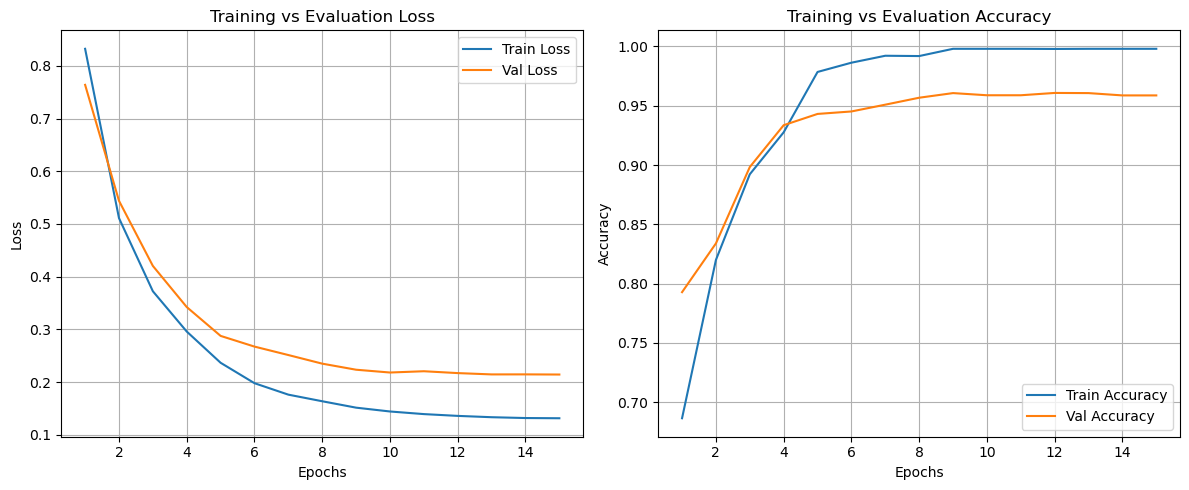

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Used as reference for plotting on the x-axis
x = range(1, len(history['train_loss']) + 1)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(x, history['train_loss'], label='Train Loss')
plt.plot(x, history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(x, history['train_acc'], label='Train Accuracy')
plt.plot(x, history['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training vs Evaluation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation
First we evaluate the (learned) student model, then the CLIP zero-shot model for benchmarking purposes.

In [20]:
# loading best saved model weights
vision_adapter_state = torch.load("vision_adapter_state.pt", weights_only=True)
text_adapter_state = torch.load("ctx_state.pt", weights_only=True)
student_model = CustomCLIP(
    CLASS_NAMES,
    clip_model,
    vision_adapter_args,
    text_adapter_args,
    vision_ratio,
    vision_adapter_state=vision_adapter_state,  # learned CLIP-adapter on the vision encoder
    text_adapter_state=text_adapter_state  # learned ctx
).to(DEVICE)

# ---- Compute accuracy on base and novel classes ----
baseLoaderTest = torch.utils.data.DataLoader(
    test_base,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)
novelLoaderTest = torch.utils.data.DataLoader(
    test_novel,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)

# evaluating CLIP zero-shot performance
print()
_, base_accuracy = eval_clip_zero_shot(clip_model, baseLoaderTest, vanilla_text_features, base_classes,)
print(f"🔍 (CLIP Zero-shot) Base classes accuracy: {base_accuracy*100:.2f}%")
_, novel_accuracy = eval_clip_zero_shot(clip_model, novelLoaderTest, vanilla_text_features, novel_classes)
print(f"🔍 (CLIP Zero-shot) Novel classes accuracy: {novel_accuracy*100:.2f}%")
print(f"🔍 (CLIP Zero-shot) Harmonic Mean: {harmonic_mean(base_accuracy, novel_accuracy)*100:.2f}%")

# evaluating student model
print()
_, base_accuracy = eval_with_class_subset(student_model, baseLoaderTest, base_classes)
print(f"🔍 (Student) Base classes accuracy: {base_accuracy*100:.2f}%")
_, novel_accuracy = eval_with_class_subset(student_model, novelLoaderTest, novel_classes)
print(f"🔍 (Student) Novel classes accuracy: {novel_accuracy*100:.2f}%")
print(f"🔍 (Student) Harmonic Mean: {harmonic_mean(base_accuracy, novel_accuracy)*100:.2f}%")

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



🔍 (CLIP Zero-shot) Base classes accuracy: 72.10%


🔍 (CLIP Zero-shot) Novel classes accuracy: 77.70%
🔍 (CLIP Zero-shot) Harmonic Mean: 74.79%



🔍 (Student) Base classes accuracy: 94.99%


🔍 (Student) Novel classes accuracy: 77.37%
🔍 (Student) Harmonic Mean: 85.28%


## Hyperparameter Search
An exhaustive hyperparameter search has been performed before finding the optimal $\mathbf {\alpha}$ and $\mathbf{\beta}$ parameters of the loss function i.e. $$\mathcal{L}_{\text{student}} = \alpha \mathcal{L}_{\text {CE}} + (1-\alpha) \mathcal{L}_{\text{vis}} + \beta \mathcal{L}_{\text{txt}}$$

The following table reports all the combinations of parameters which have been tested and the best ones are $\mathcal{\alpha} = 0.6$ and $\mathcal{\beta} = 1$.

<div style="text-align: center;">

<img src="https://i.postimg.cc/Y0GnvNCd/hyperparam-study-analysis.png" alt="alpha and beta hyperparameter study" width="900">

*Figure 1: Base, Novel and Harmonic Mean heatmap on all many parameter combination.* 
</div>

Intuitively it's clear how **increasing** the $\mathbf{\alpha}$ parameter allows the model to learn more task-specific knowledge giving more importance to the Cross-Entropy loss, hence increasing base classes accuracy. On the other hand, the **higher** the $\mathbf{\beta}$ parameter, the more importance is given to making sure learned text embeddings don't drift too far from the hand-crafted ones, hence increasing novel classes accuracy. The *sweet spot* was found in-between.

# Conclusions
The combined approach effectively addressed the issues which famous prompt-tuning and adapter methods had i.e. dealing with a single modality (language and vision respectively) without leveraging cues from the other.
From this study it was clear how important it is to avoid learning both textual and visual features that drift too far from the *CLIP Zero-Shot* ones in the shared embedding space in order to avoid catastrophic performance drops for unseen classes. This intuitively make sense as it reflects how CLIP was trained and, when disrupting such properties, without a clear signal to avoid diverging too much from original features, then the trained parameters would make the model overfit on seen classes.

Performance-wise, the implemented method yields incredible results in both base and novel performance and from the hyperparameter search analysis something interesting emerged i.e. the upper bound on *novel* classes performance remains CLIP zero-shot.

# Final Notes
After developing this method, we found a paper ([KgCoOp](https://arxiv.org/pdf/2303.13283)) which simply adds the textual loss between the learned prompt by CoOp and the hand-crafted one like the one implemented in this project i.e. $\mathcal L_{txt}$. Their results are inferior to those obtained with this method (95.00 on base, 74.73 on novel and 83.65 HM) and the reported results are also obtained from training with 16 shots instead of 10 like in this setting. Although they achieved impressive results, their implementation is still not accounting for the *visual side* of the problem, hence yielding inferior results.

# References
[CLIP](https://arxiv.org/abs/2103.00020) Radford et al., Learning Transferable Visual Models from Natural Language Supervision, ICML 2021.

[CoOp](https://arxiv.org/pdf/2109.01134) Zhou et al., Learning to Prompt for Vision-Language Models, IJCV 2022.

[CLIP-Adapter](https://arxiv.org/pdf/2110.04544) Gao et al., CLIP-Adapter: Better Vision-Language Models with Feature Adapters, IJCV 2024.

[KgCoOp](https://arxiv.org/pdf/2303.13283) Yao et al., Visual-Language Prompt Tuning with Knowledge-guided Context Optimization, CVPR 2023.